In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.calculators.lammpslib import LAMMPSlib
from ase.lattice.hexagonal import Graphene
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.io.trajectory import Trajectory

from abtem import *
from abtem.structures import orthogonalize_cell
from abtem.temperature import MDFrozenPhonons

In [2]:
cmds = ['pair_style tersoff',
        'pair_coeff * * BNC.tersoff B N']

lammps = LAMMPSlib(lmpcmds=cmds, log_file=None, keep_alive=True)

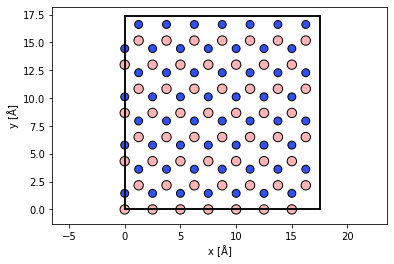

In [16]:
atoms = Graphene(symbol='N', latticeconstant={'a':2.502, 'c': 12})

atoms[0].symbol = 'B'

atoms = orthogonalize_cell(atoms)

repetitions = (7,4,1)

atoms *= repetitions

atoms.center(axis=2)

show_atoms(atoms);

In [17]:
atoms.set_calculator(lammps)
print(f'Energy {atoms.get_potential_energy()}')

Energy -840.7489536458229


In [18]:
def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'Energy per atom: Epot = {epot:.3f} eV  Ekin = {ekin:.3f} eV (T = {ekin / (1.5 * units.kB):.3f} K) '
          f'Etot = {epot + ekin:.3f}eV')

In [19]:
# Set the momenta corresponding to T=1000K (the temperature will drop)

loginterval = 100
timestep = .1 * units.fs

MaxwellBoltzmannDistribution(atoms, 1000 * units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm and save the trajectory file.
dyn = VelocityVerlet(atoms, timestep, trajectory='hbn.traj', loginterval=loginterval)
dyn.attach(printenergy, interval=1000)

# Now run the dynamics for 10000 timesteps.
dyn.run(10000)

Energy per atom: Epot = -7.507 eV  Ekin = 0.118 eV (T = 910.847 K) Etot = -7.389eV
Energy per atom: Epot = -7.441 eV  Ekin = 0.052 eV (T = 402.301 K) Etot = -7.389eV
Energy per atom: Epot = -7.458 eV  Ekin = 0.069 eV (T = 530.790 K) Etot = -7.389eV
Energy per atom: Epot = -7.449 eV  Ekin = 0.060 eV (T = 462.020 K) Etot = -7.389eV
Energy per atom: Epot = -7.444 eV  Ekin = 0.055 eV (T = 423.664 K) Etot = -7.389eV
Energy per atom: Epot = -7.445 eV  Ekin = 0.056 eV (T = 435.480 K) Etot = -7.389eV
Energy per atom: Epot = -7.441 eV  Ekin = 0.052 eV (T = 399.208 K) Etot = -7.389eV
Energy per atom: Epot = -7.447 eV  Ekin = 0.058 eV (T = 446.326 K) Etot = -7.389eV
Energy per atom: Epot = -7.450 eV  Ekin = 0.061 eV (T = 472.333 K) Etot = -7.389eV
Energy per atom: Epot = -7.447 eV  Ekin = 0.058 eV (T = 448.626 K) Etot = -7.389eV
Energy per atom: Epot = -7.448 eV  Ekin = 0.059 eV (T = 456.555 K) Etot = -7.389eV


True

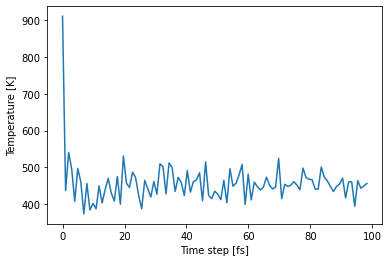

In [20]:
traj = Trajectory('hbn.traj', 'r')

time_step = np.linspace(0,(len(traj)-1)*loginterval*timestep,len(traj))
energies = [atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms)) for atoms in traj]

plt.plot(time_step, energies)
plt.xlabel('Time step [fs]')
plt.ylabel('Temperature [K]');

In [39]:
random_ensemble = [traj[i] for i in np.random.choice(range(20,len(traj)), 1, replace=False)]

In [55]:
frozen_phonons = MDFrozenPhonons(random_ensemble)

potential = Potential(frozen_phonons, gpts=1024)

potential.sampling

(0.017103515625, 0.016928090314598947)

In [23]:
plane_wave = PlaneWave(energy=300e3)
exit_waves = plane_wave.multislice(potential)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f5d781e2fa0>)

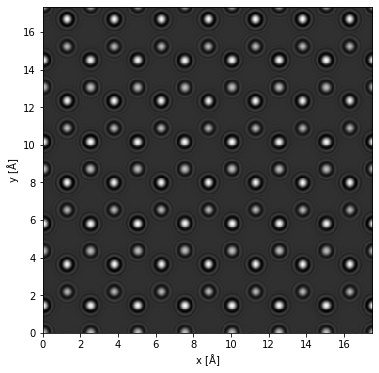

In [56]:
exit_waves.intensity().mean(0).show(figsize=(6,6))

In [64]:
S = SMatrix(energy=80e3, semiangle_cutoff=20, expansion_cutoff=20, interpolation=2, device='gpu')
S.grid.match(potential)

S.profile().show()

RuntimeError: CuPy is not installed, only CPU calculations available

In [63]:
scan = GridScan((0,0), (potential.extent[0], potential.extent[1]), sampling=.2)

detector = FlexibleAnnularDetector()
detector = AnnularDetector(0,12)

measurements = S.scan(scan, [detector], potential)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f5d72b39f10>)

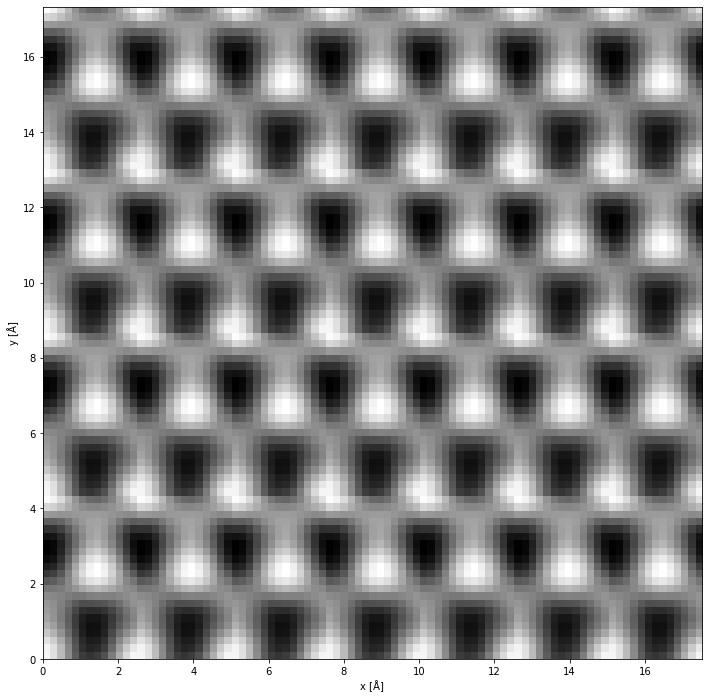

In [62]:
measurements[detector].show(figsize=(12,12))

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f5d70d86ca0>)

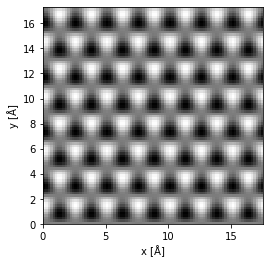

In [33]:
measurements[detector].integrate(50,200).tile(repetitions[:2]).show()